# Bagging (회귀) 하이퍼파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.regression import *

# 최적의 성능을 보이는 모델
from sklearn.tree import DecisionTreeRegressor

# 배깅 회귀
from sklearn.ensemble import BaggingRegressor

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)


상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 

### [3] 훈련/검증 데이터 분할 및 데이터 표준화

In [3]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, 'MEDV', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

## #02. 하이퍼파라미터 튜닝

### [1] 최적 성능을 보인 모형

#### (1) 모형 객체 생성

이전 예제에서 이 데이터에 대한 최적 모형은 의사결정나무 모형이었다.

In [4]:
estimator = get_estimator(classname=DecisionTreeRegressor)
estimator

DecisionTreeRegressor(random_state=1000)

#### (2) 최적성능을 보인 모형에 대한 하이퍼파라미터

In [5]:
params = get_hyper_params(classname=DecisionTreeRegressor, key='estimator')
params

{}

### [2] Bagging 모형에 대한 하이퍼 파라미터

In [6]:
bagging_params = get_hyper_params(classname=BaggingClassifier)
bagging_params

{'bootstrap_features': [False, True],
 'n_estimators': [2, 5, 10, 20],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

### [3] 하이퍼파라미터 결합

In [7]:
params.update(bagging_params)
params

{'bootstrap_features': [False, True],
 'n_estimators': [2, 5, 10, 20],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

In [8]:
rcv = RandomizedSearchCV(
    estimator=BaggingRegressor(estimator=estimator, random_state=get_random_state()), 
    param_distributions=params, 
    n_iter=get_max_iter(), 
    n_jobs=get_n_jobs(),
    random_state=get_random_state(), 
    cv=5)

rcv.fit(x_train, y_train)

result_df = DataFrame(rcv.cv_results_['params'])
result_df['mean_test_score'] = rcv.cv_results_['mean_test_score']
result_df.dropna(subset=['mean_test_score'], inplace=True)
result_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

result_df

C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,n_estimators,max_samples,max_features,bootstrap_features,mean_test_score
30,10,0.7,1.0,False,0.810425
23,20,1.0,0.7,False,0.808519
19,20,0.7,0.7,False,0.805826
63,20,0.5,1.0,True,0.805465
26,10,0.5,1.0,False,0.804468
...,...,...,...,...,...
36,2,0.5,0.5,True,0.594187
40,2,0.7,0.5,True,0.580651
0,2,0.5,0.5,False,0.534115
4,2,0.7,0.5,False,0.507553


[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.954168 |     0.884105 |
| 평균절대오차(MAE)             |      1.23094 |      2.20657 |
| 평균제곱오차(MSE)             |      3.85716 |      9.88765 |
| 평균오차(RMSE)                |      1.96396 |      3.14446 |
| 평균 절대 백분오차 비율(MAPE) |      5.98601 |      12.1659 |
| 평균 비율 오차(MPE)           |     -1.02675 |     -4.75768 |
+-------------------------------+--------------+--------------+

[학습곡선]


C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 970, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\yjg1

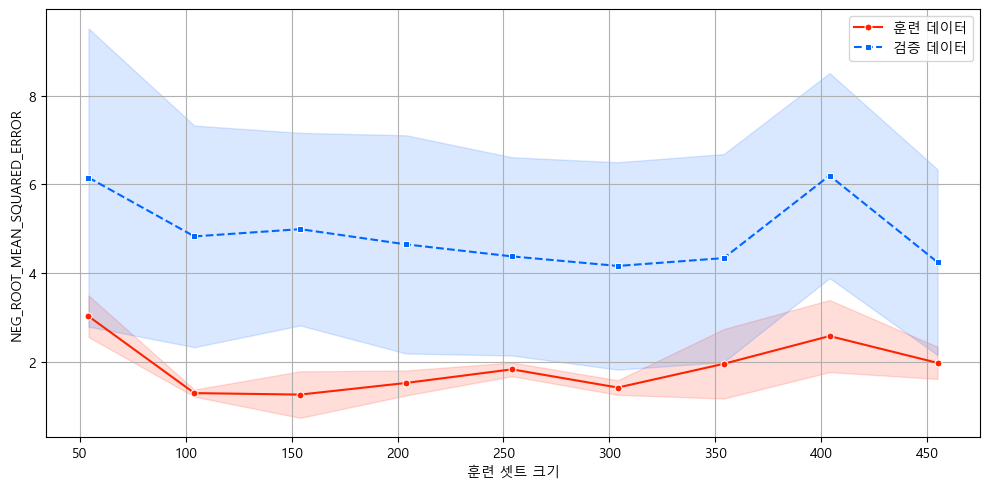

In [9]:
my_regression_result(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [10]:
my_regression_report(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 3.31189 |
|  1 | MEDV       | ZN         | 3.19958 |
|  2 | MEDV       | INDUS      | 4.74148 |
|  3 | MEDV       | CHAS       | 1.13018 |
|  4 | MEDV       | NOX        | 6.11484 |
|  5 | MEDV       | RM         | 2.04028 |
|  6 | MEDV       | AGE        | 3.15955 |
|  7 | MEDV       | DIS        | 4.92998 |
|  8 | MEDV       | RAD        | 10.6946 |
|  9 | MEDV       | TAX        | 12.7292 |
| 10 | MEDV       | PTRATIO    | 2.37277 |
| 11 | MEDV       | B          | 1.39447 |
| 12 | MEDV       | LSTAT      | 4.52044 |
+----+------------+------------+---------+



## #03. 모듈 기능 확인

분류분석과 마찬가지로 3가지 경우로 사용할 수 있음

가지치기를 하지 않습니다.


C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=1000. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=1000. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=1000. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=1000. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[core.py:233] <class 'joblib.externals.loky.process_executor.ShutdownExecutorError'> cannot schedule new futures after shutdown
[<class 'sklearn.linear_model._coordinate_descent.Lasso'> 모델의 학습에 실패했습니다.
[core.py:233] <class 'joblib.externals.loky.process_executor.ShutdownExecutorError'> cannot schedule new futures after shutdown
[<class 'sklearn.linear_model._ridge.Ridge'> 모델의 학습에 실패했습니다.


C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(




==================== 모델 성능 비교 ====================
+-----------------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|                       |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|-----------------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| LinearRegression      |       0.694283 |             3.60137 |             26.0824 |          5.10709 |                         19.3308 |              -7.30724 |
| KNeighborsRegressor   |       0.697567 |             3.05621 |             25.8022 |          5.07958 |                         15.2172 |              -1.26667 |
| SVR                   |       0.700663 |             3.32961 |              25.538 |          5.05351 |                         17.6917 |              -2.30743 |

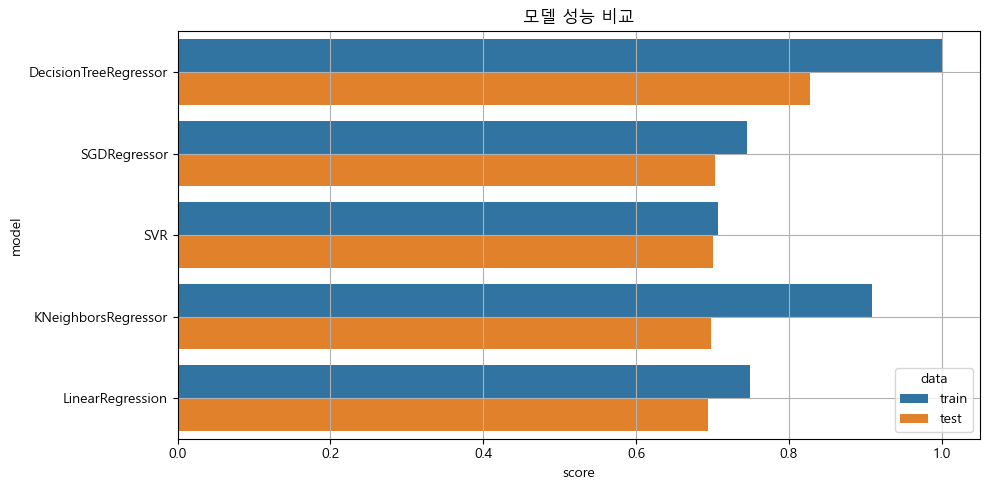

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |            1 |      0.82721 |
| 평균절대오차(MAE)             |            0 |      2.60294 |
| 평균제곱오차(MSE)             |            0 |      14.7417 |
| 평균오차(RMSE)                |            0 |      3.83949 |
| 평균 절대 백분오차 비율(MAPE) |            0 |      13.2738 |
| 평균 비율 오차(MPE)           |            0 |     -3.43776 |
+-------------------------------+--------------+--------------+

[학습곡선]


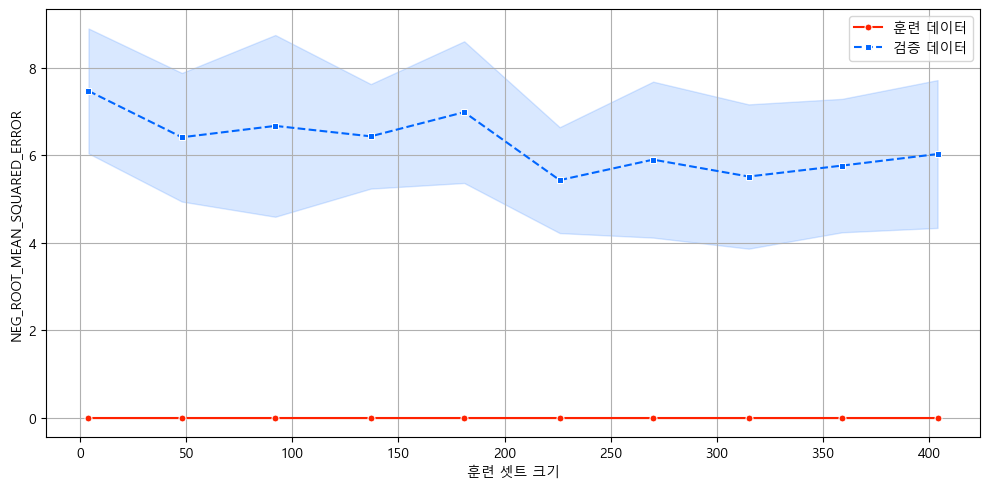

C:\Users\yjg10\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[교차검증 TOP5]
+----+----------------+---------------+----------------+----------------------+-------------------+
|    |   n_estimators |   max_samples |   max_features | bootstrap_features   |   mean_test_score |
|----+----------------+---------------+----------------+----------------------+-------------------|
|  0 |             10 |           0.7 |              1 | False                |          0.810425 |
|  1 |             20 |             1 |            0.7 | False                |          0.808519 |
|  2 |             20 |           0.7 |            0.7 | False                |          0.805826 |
|  3 |             20 |           0.5 |              1 | True                 |          0.805465 |
|  4 |             10 |           0.5 |              1 | False                |          0.804468 |
+----+----------------+---------------+----------------+----------------------+-------------------+

[Best Params]
{'n_estimators': 10, 'max_samples': 0.7, 'max_features': 1.0, 'bootstrap_

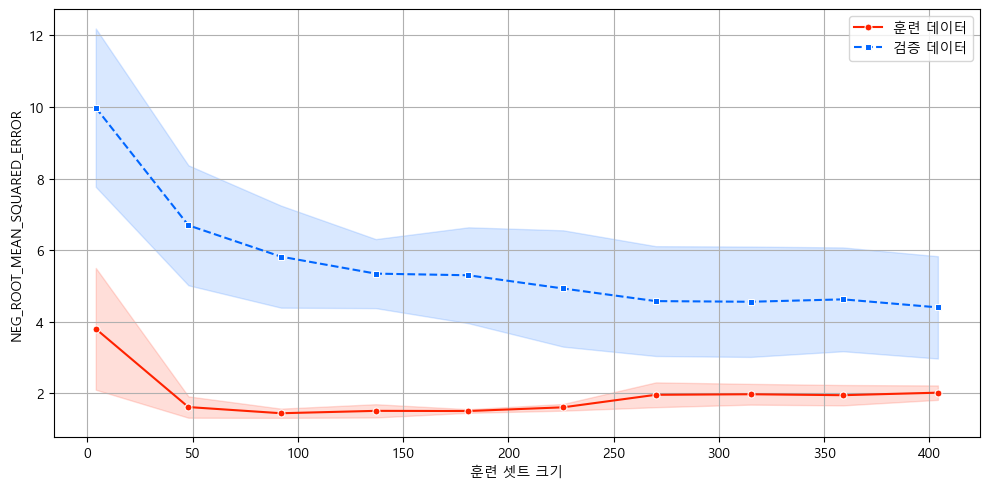


+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 3.31189 |
|  1 | MEDV       | ZN         | 3.19958 |
|  2 | MEDV       | INDUS      | 4.74148 |
|  3 | MEDV       | CHAS       | 1.13018 |
|  4 | MEDV       | NOX        | 6.11484 |
|  5 | MEDV       | RM         | 2.04028 |
|  6 | MEDV       | AGE        | 3.15955 |
|  7 | MEDV       | DIS        | 4.92998 |
|  8 | MEDV       | RAD        | 10.6946 |
|  9 | MEDV       | TAX        | 12.7292 |
| 10 | MEDV       | PTRATIO    | 2.37277 |
| 11 | MEDV       | B          | 1.39447 |
| 12 | MEDV       | LSTAT      | 4.52044 |
+----+------------+------------+---------+



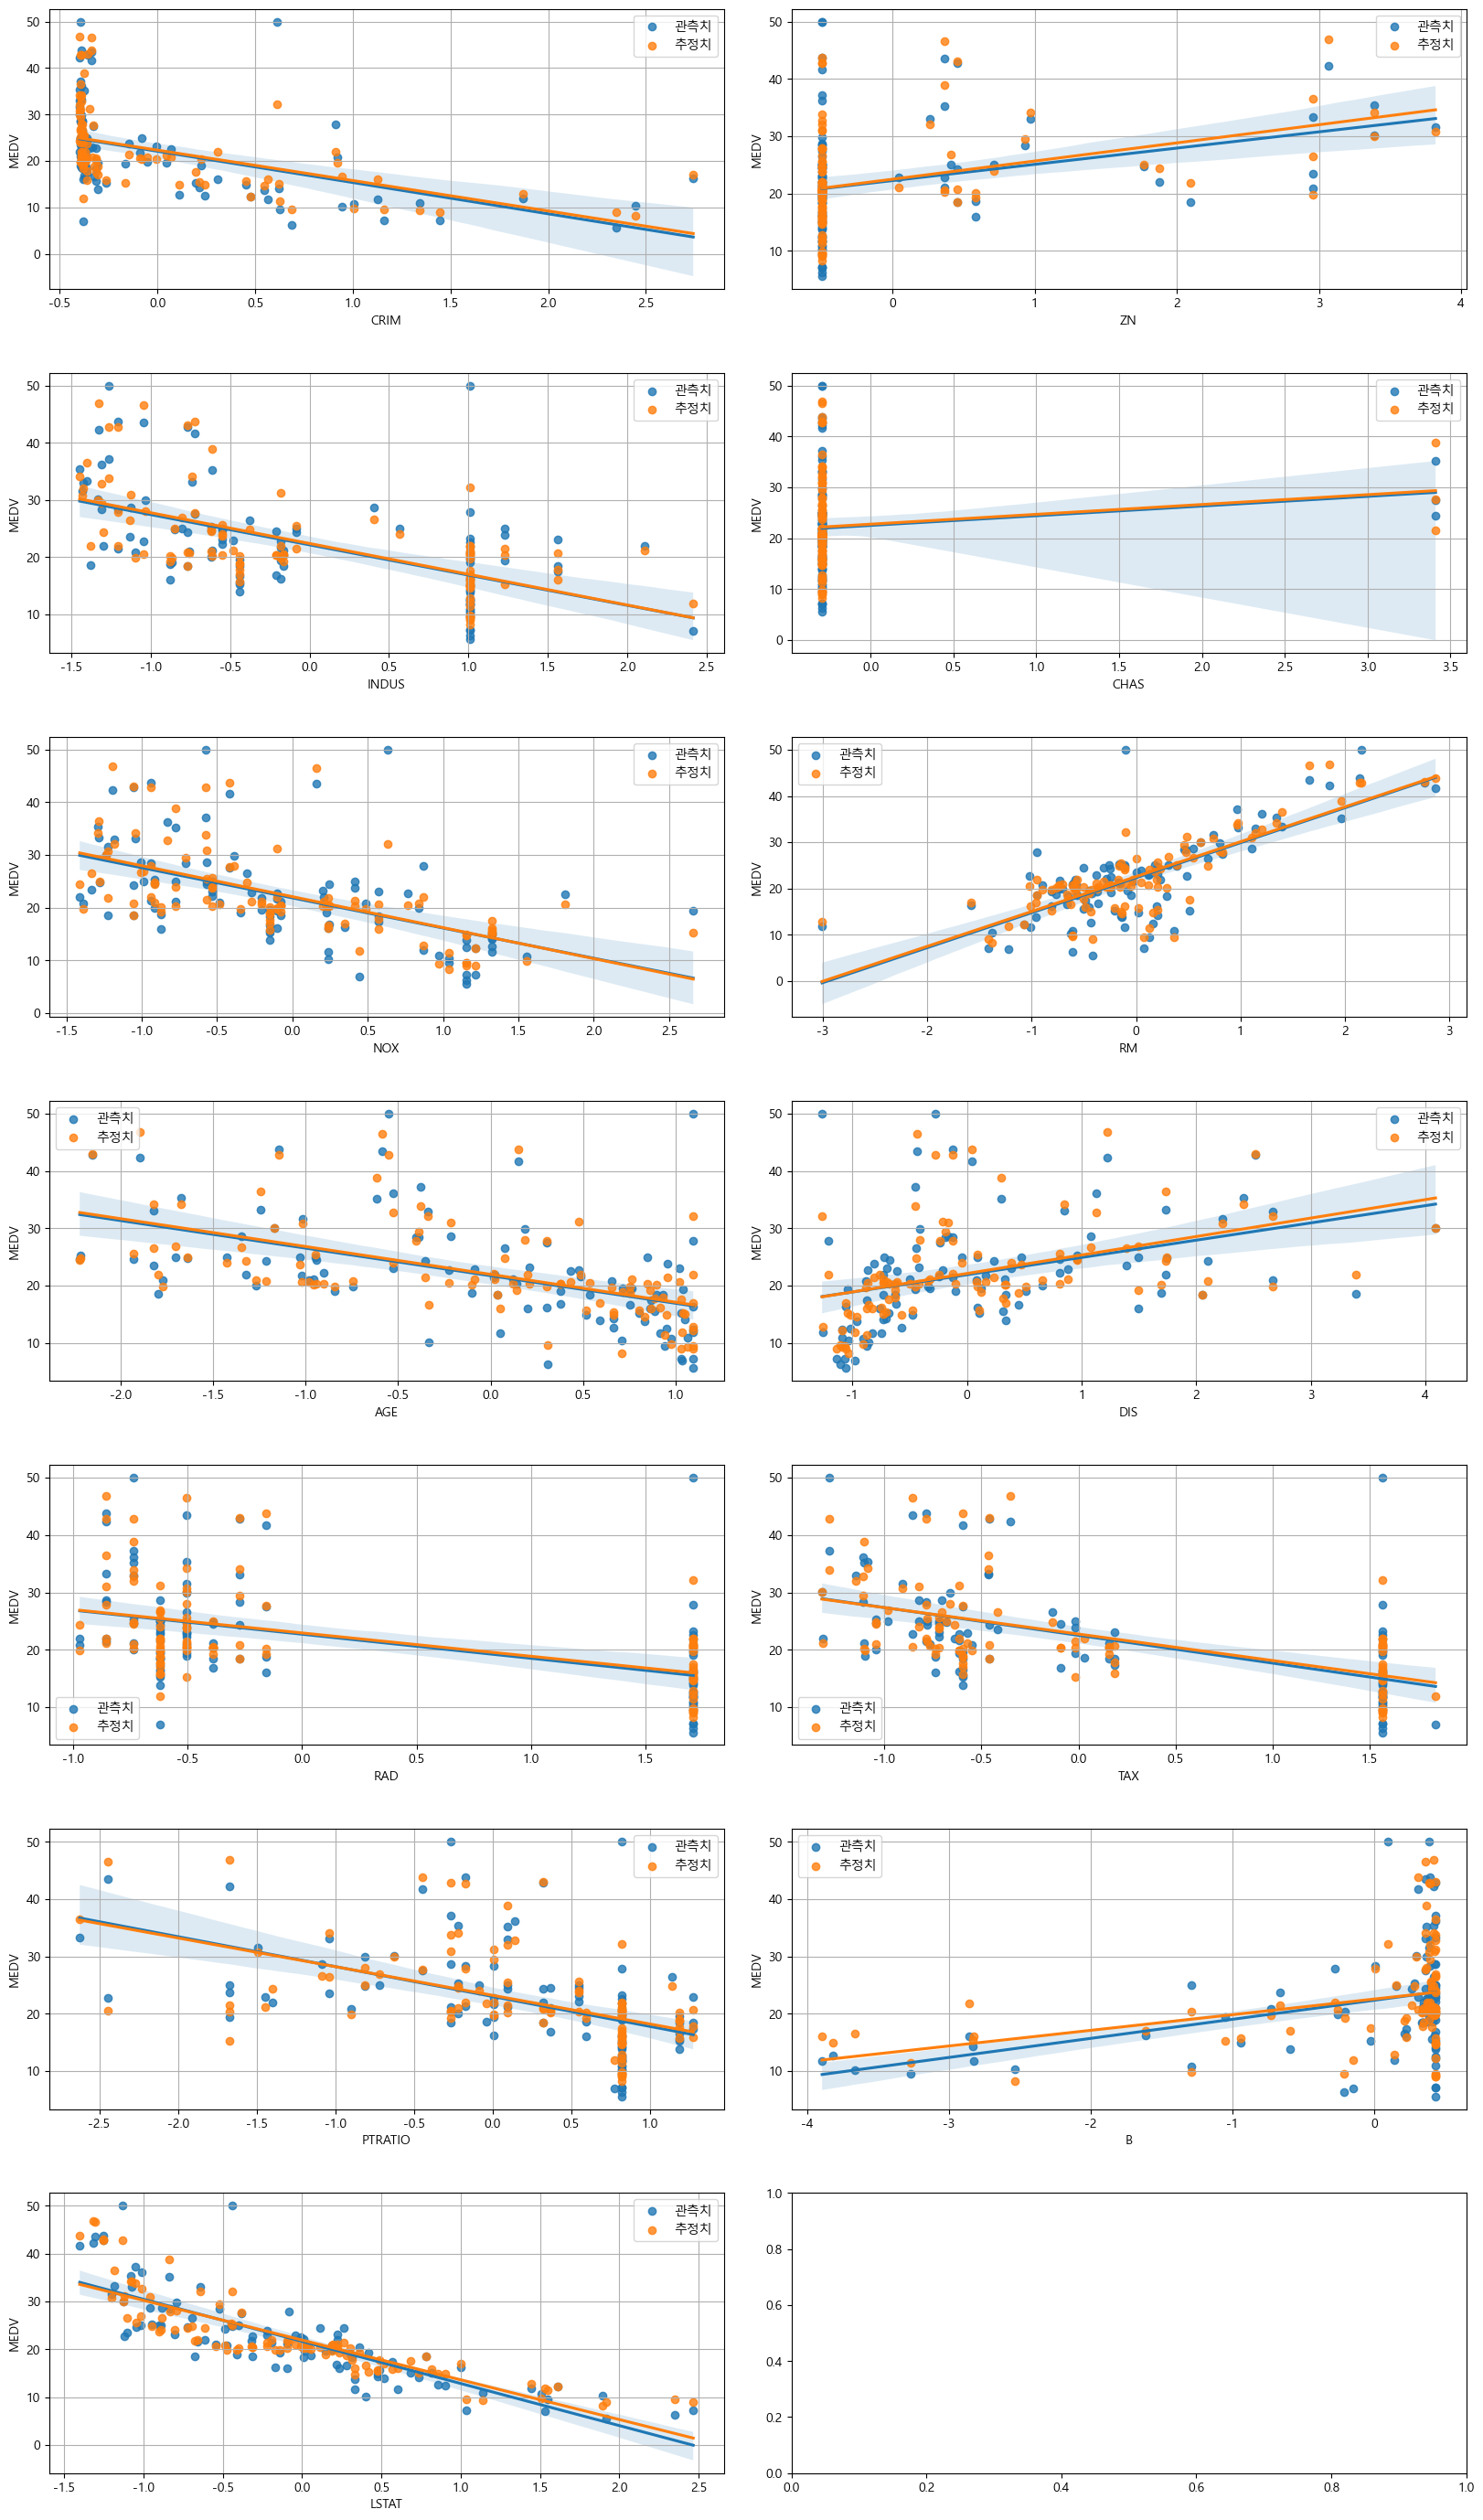

BaggingRegressor(estimator=DecisionTreeRegressor(random_state=1000),
                 max_samples=0.7, n_jobs=2, random_state=1000)

In [11]:
my_bagging_regression(x_train, y_train, x_test, y_test)